In [6]:
# --- solid loader ---
import spacy

def load_nlp():
    # scispaCy
    try:
        return spacy.load("en_core_sci_sm")
    except Exception:
        pass
    # spaCy small
    try:
        return spacy.load("en_core_web_sm")
    except Exception:
        pass
    # blank fallback
    nlp = spacy.blank("en")
    # minimalist lemmatizer (opcjonalnie, jeśli brak lookups)
    try:
        nlp.add_pipe("lemmatizer", config={"mode":"rule"})
        nlp.initialize()
    except Exception:
        pass
    return nlp

nlp = load_nlp()
print("Loaded pipeline:", nlp.meta.get("name", "blank-en"))
import re, string, pandas as pd

df = pd.read_csv("variant_12_neuro.csv", encoding="utf-8")

def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"https?://\S+", " ", s)
    s = re.sub(r"\d+", " ", s)
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["clean"] = df["text"].astype(str).apply(clean_text)

def to_lemma(s: str) -> str:
    try:
        doc = nlp(s)
        toks = [t.lemma_ for t in doc if not t.is_punct and not t.is_space and not t.is_stop]
        # gdy brak lemmatizera → spadnie do oryginału
        toks = [w if (w and w != "-PRON-") else t.text for w,t in zip(toks, doc)]
        return " ".join(toks) if toks else s
    except Exception:
        return s

df["lemma"] = df["clean"].apply(to_lemma)
df[["text","clean","lemma"]].head()


Loaded pipeline: core_sci_sm


,text,clean,lemma
0,CT brain shows right basal ganglia infarct. Le...,ct brain shows right basal ganglia infarct lef...,ct brain show right basal ganglia infarct left...
1,MRI brain reveals demyelinating plaques sugges...,mri brain reveals demyelinating plaques sugges...,mri brain reveal demyelinate plaque suggestive...
2,EEG shows generalized spike-wave activity. Dia...,eeg shows generalized spikewave activity diagn...,eeg show generalize spikewave activity diagnos...
3,CT head normal. Symptoms consistent with tensi...,ct head normal symptoms consistent with tensio...,ct head normal symptom consistent tension head...
4,MRI spine demonstrates herniated disc at L5–S1...,mri spine demonstrates herniated disc at l –s ...,mri spine demonstrate herniate disc l –s leg p...


In [9]:
# === Etap 2: NER (słownik + regex) ===
import re
from collections import Counter
from itertools import chain

base_col = "lemma" if "lemma" in df.columns else ("clean" if "clean" in df.columns else "text")

LEX = {
    "DISEASE": [
        "tension headache","multiple sclerosis","herniated disc","disc herniation",
        "myocardial infarction","cerebral infarct","brain infarct","epilepsy",
        "stroke","hypertension","pneumonia","infarct","ms","basal ganglia infarct"
    ],
    "DRUG": [
        "aspirin","ibuprofen","metformin","amoxicillin","lisinopril","statin","clopidogrel","ppi","salbutamol"
    ],
    "PROCEDURE": [
        "magnetic resonance imaging","computed tomography","electroencephalography",
        "lumbar puncture","angiography","biopsy","endoscopy","ct scan","eeg","mri","ct"
    ],
}

PAT = {
    lab: [re.compile(rf"(?<!\w){re.escape(w)}(?!\w)", re.IGNORECASE)
          for w in sorted(set(words), key=len, reverse=True)]
    for lab, words in LEX.items()
}

def simple_dict_ner_regex(texts):
    out = []
    for s in texts:
        low = s.lower()
        ents = []
        for label, regs in PAT.items():
            for rgx in regs:
                for m in rgx.finditer(low):
                    ents.append((s[m.start():m.end()], label))
        seen, uniq = set(), []
        for span, lab in sorted(ents, key=lambda x: (-len(x[0]), x[0].lower())):
            key = (span.lower(), lab)
            if key not in seen:
                seen.add(key); uniq.append((span, lab))
        out.append(uniq)
    return out

df["entities"] = simple_dict_ner_regex(df[base_col].astype(str).tolist())

flat = list(chain.from_iterable(df["entities"]))
cnt_all = Counter([f"{t.lower()}|{l}" for t,l in flat])
cnt_dis = Counter([t.lower() for t,l in flat if l=="DISEASE"])
cnt_drug = Counter([t.lower() for t,l in flat if l=="DRUG"])
cnt_proc = Counter([t.lower() for t,l in flat if l=="PROCEDURE"])

print("Top ALL:", cnt_all.most_common(20))
print("Top DISEASE:", cnt_dis.most_common(10))
print("Top DRUG:", cnt_drug.most_common(10))
print("Top PROCEDURE:", cnt_proc.most_common(10))

df[["text","entities"]].head(10)


Top ALL: [('ct|PROCEDURE', 2), ('mri|PROCEDURE', 2), ('basal ganglia infarct|DISEASE', 1), ('infarct|DISEASE', 1), ('multiple sclerosis|DISEASE', 1), ('epilepsy|DISEASE', 1), ('eeg|PROCEDURE', 1), ('tension headache|DISEASE', 1)]
Top DISEASE: [('basal ganglia infarct', 1), ('infarct', 1), ('multiple sclerosis', 1), ('epilepsy', 1), ('tension headache', 1)]
Top DRUG: []
Top PROCEDURE: [('ct', 2), ('mri', 2), ('eeg', 1)]


,text,entities
0,CT brain shows right basal ganglia infarct. Le...,"[(basal ganglia infarct, DISEASE), (infarct, D..."
1,MRI brain reveals demyelinating plaques sugges...,"[(multiple sclerosis, DISEASE), (mri, PROCEDURE)]"
2,EEG shows generalized spike-wave activity. Dia...,"[(epilepsy, DISEASE), (eeg, PROCEDURE)]"
3,CT head normal. Symptoms consistent with tensi...,"[(tension headache, DISEASE), (ct, PROCEDURE)]"
4,MRI spine demonstrates herniated disc at L5–S1...,"[(mri, PROCEDURE)]"


In [11]:
# === Etap 3: porównanie modeli na bardzo małej próbce (LOO) ===
import numpy as np, pandas as pd, re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from collections import Counter

base_col = "lemma" if "lemma" in df.columns else ("clean" if "clean" in df.columns else "text")
X = df[base_col].astype(str).values
y = df["label"].astype(str).values

def loo_eval(vec, clf, X, y):
    loo = LeaveOneOut()
    yt, yp = [], []
    for tr, te in loo.split(X):
        Xtr = vec.fit_transform(X[tr]); Xte = vec.transform(X[te])
        clf.fit(Xtr, y[tr]); yp.append(clf.predict(Xte)[0]); yt.append(y[te][0])
    acc = accuracy_score(yt, yp)
    p, r, f1, _ = precision_recall_fscore_support(yt, yp, average="macro", zero_division=0)
    print("Acc:", round(acc,3), "| P:", round(p,3), "R:", round(r,3), "F1:", round(f1,3))
    print(classification_report(yt, yp, digits=3, zero_division=0))
    return yp

# 1) word n-grams
vec_w = TfidfVectorizer(ngram_range=(1,2), stop_words="english", sublinear_tf=True, min_df=1)
clf = LinearSVC(class_weight="balanced", dual="auto")
print("\n=== LinearSVC word n-grams (1–2) ===")
yp_w = loo_eval(vec_w, clf, X, y)

# 2) char n-grams
vec_c = TfidfVectorizer(analyzer="char", ngram_range=(3,5), sublinear_tf=True, min_df=1)
clf2 = LinearSVC(class_weight="balanced", dual="auto")
print("\n=== LinearSVC char n-grams (3–5) ===")
yp_c = loo_eval(vec_c, clf2, X, y)

# 3) regułowy baseline (z encji/tekstu → etykieta)
KEY2LABEL = [
    (["multiple sclerosis"," ms "], "ms"),
    (["tension headache"," headache "], "headache"),
    (["herniated disc","disc herniation"," spine "], "spine"),
    (["epilepsy","spike-wave"," spike wave "], "epilepsy"),
    (["basal ganglia infarct","infarct"," stroke "], "stroke"),
]
def rule_predict_one(s, ents=None):
    txt = f" {s.lower()} "
    hits = []
    if ents is not None:
        lowents = [e[0].lower() for e in ents]
        for pat, lab in KEY2LABEL:
            if any(any(k.strip() in le for le in lowents) for k in pat): hits.append(lab)
    for pat, lab in KEY2LABEL:
        if any(k in txt for k in pat): hits.append(lab)
    if hits:
        c = Counter(hits).most_common(1)[0][0]
        return c
    return None

ents_col = "entities" if "entities" in df.columns else None
print("\n=== Rule-based baseline ===")
yt, yp = [], []
for i, row in df.iterrows():
    pred = rule_predict_one(row[base_col], row[ents_col] if ents_col else None)
    yp.append(pred if pred else "unknown")
    yt.append(row["label"])
acc = accuracy_score(yt, yp)
p, r, f1, _ = precision_recall_fscore_support(yt, yp, average="macro", zero_division=0)
print("Acc:", round(acc,3), "| P:", round(p,3), "R:", round(r,3), "F1:", round(f1,3))
print(classification_report(yt, yp, digits=3, zero_division=0))

# model finalny (fit na całości) – char n-grams
vec_final = TfidfVectorizer(analyzer="char", ngram_range=(3,5), sublinear_tf=True, min_df=1)
Xv = vec_final.fit_transform(X)
clf_final = LinearSVC(class_weight="balanced", dual="auto").fit(Xv, y)
print("\nFinal: LinearSVC + char(3–5) dopasowany na całości.")



=== LinearSVC word n-grams (1–2) ===
Acc: 0.0 | P: 0.0 R: 0.0 F1: 0.0
              precision    recall  f1-score   support

    epilepsy      0.000     0.000     0.000       1.0
    headache      0.000     0.000     0.000       1.0
          ms      0.000     0.000     0.000       1.0
       spine      0.000     0.000     0.000       1.0
      stroke      0.000     0.000     0.000       1.0

    accuracy                          0.000       5.0
   macro avg      0.000     0.000     0.000       5.0
weighted avg      0.000     0.000     0.000       5.0


=== LinearSVC char n-grams (3–5) ===
Acc: 0.0 | P: 0.0 R: 0.0 F1: 0.0
              precision    recall  f1-score   support

    epilepsy      0.000     0.000     0.000       1.0
    headache      0.000     0.000     0.000       1.0
          ms      0.000     0.000     0.000       1.0
       spine      0.000     0.000     0.000       1.0
      stroke      0.000     0.000     0.000       1.0

    accuracy                          0.000

=== Podświetlenie encji (3 przykłady) ===

#0
[ct<PROCEDURE>] brain shows right [basal ganglia [infarct<DISEASE>]<DISEASE>]. Left-sided weakness noted.

#1
[mri<PROCEDURE>] brain reveals demyelinating plaques suggestive of [multiple sclerosis<DISEASE>].

#2
[eeg<PROCEDURE>] shows generalized spike-wave activity. Diagnosis: [epilepsy<DISEASE>].


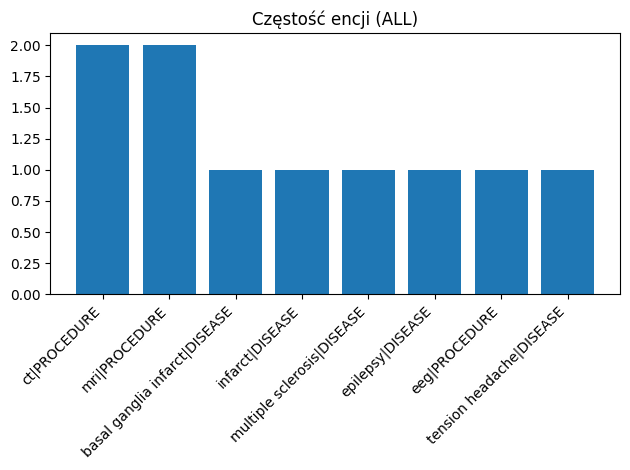

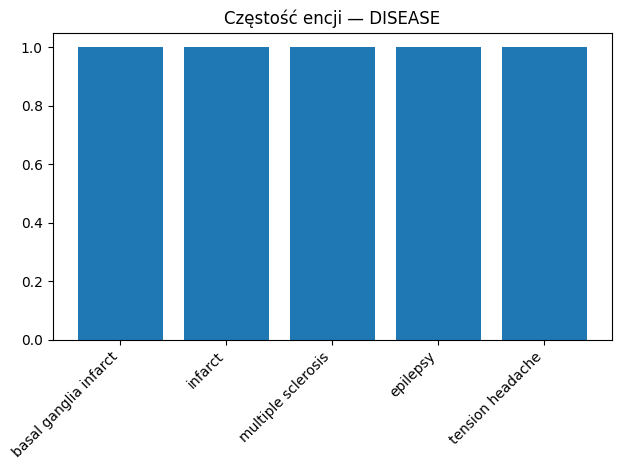

Częstość encji — DRUG: brak danych


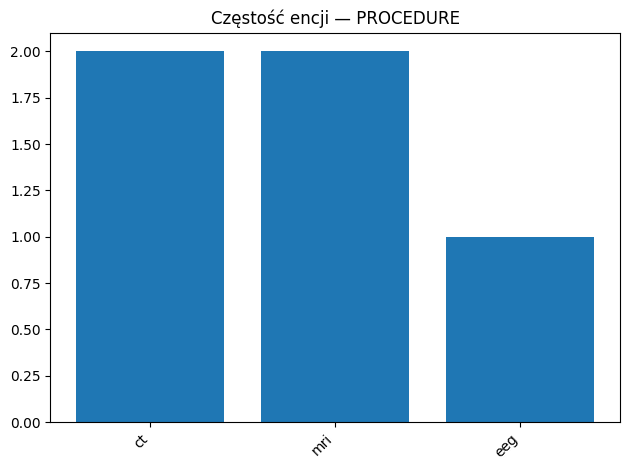


=== Raport LOO ===
              precision    recall  f1-score   support

    epilepsy      0.000     0.000     0.000       1.0
    headache      0.000     0.000     0.000       1.0
          ms      0.000     0.000     0.000       1.0
       spine      0.000     0.000     0.000       1.0
      stroke      0.000     0.000     0.000       1.0

    accuracy                          0.000       5.0
   macro avg      0.000     0.000     0.000       5.0
weighted avg      0.000     0.000     0.000       5.0



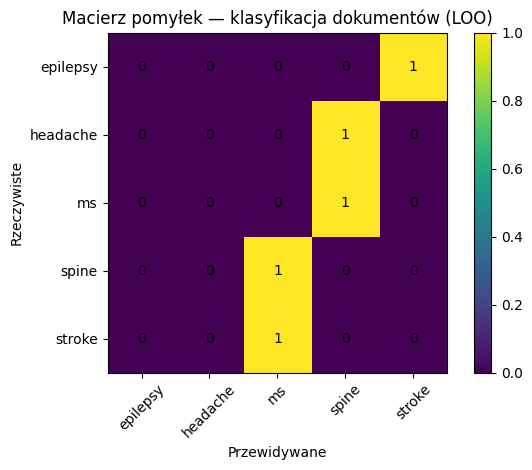


=== Błędy klasyfikacji (z kontekstem) ===

Próbka #0 | true=stroke pred=ms
Tekst: CT brain shows right basal ganglia infarct. Left-sided weakness noted.
Encje: [('basal ganglia infarct', 'DISEASE'), ('infarct', 'DISEASE'), ('ct', 'PROCEDURE')]

Próbka #1 | true=ms pred=spine
Tekst: MRI brain reveals demyelinating plaques suggestive of multiple sclerosis.
Encje: [('multiple sclerosis', 'DISEASE'), ('mri', 'PROCEDURE')]

Próbka #2 | true=epilepsy pred=stroke
Tekst: EEG shows generalized spike-wave activity. Diagnosis: epilepsy.
Encje: [('epilepsy', 'DISEASE'), ('eeg', 'PROCEDURE')]

Próbka #3 | true=headache pred=spine
Tekst: CT head normal. Symptoms consistent with tension headache.
Encje: [('tension headache', 'DISEASE'), ('ct', 'PROCEDURE')]

Próbka #4 | true=spine pred=ms
Tekst: MRI spine demonstrates herniated disc at L5–S1. Leg pain persists.
Encje: [('mri', 'PROCEDURE')]


In [12]:
# === Etap 4: Wizualizacja i interpretacja wyników ===
import re, numpy as np, matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report

# kolumny bazowe
base_col = "lemma" if "lemma" in df.columns else ("clean" if "clean" in df.columns else "text")
X = df[base_col].astype(str).values
y = df["label"].astype(str).values

# --- podświetlanie encji ---
def highlight_entities(text, entities):
    ents_sorted = sorted(entities, key=lambda x: (-len(x[0]), x[0].lower()))
    s = text
    for ent, lab in ents_sorted:
        rgx = re.compile(rf"(?<!\w){re.escape(ent)}(?!\w)", re.IGNORECASE)
        s = rgx.sub(f"[{ent}<{lab}>]", s)
    return s

print("=== Podświetlenie encji (3 przykłady) ===")
for i in range(min(3, len(df))):
    t = df.loc[i, "text"]
    ents = df.loc[i, "entities"]
    print(f"\n#{i}\n" + highlight_entities(t, ents))

# --- częstości encji (ALL i per typ) ---
flat = list(chain.from_iterable(df["entities"]))
cnt_all = Counter([f"{t.lower()}|{l}" for t,l in flat])
cnt_dis = Counter([t.lower() for t,l in flat if l=="DISEASE"])
cnt_drug = Counter([t.lower() for t,l in flat if l=="DRUG"])
cnt_proc = Counter([t.lower() for t,l in flat if l=="PROCEDURE"])

def plot_bar(counter, title, top=15):
    items = counter.most_common(top)
    if not items: 
        print(f"{title}: brak danych"); 
        return
    labels, vals = zip(*items)
    plt.figure()
    plt.bar(range(len(vals)), vals)
    plt.title(title)
    plt.xticks(range(len(vals)), labels, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_bar(cnt_all, "Częstość encji (ALL)")
plot_bar(cnt_dis, "Częstość encji — DISEASE")
plot_bar(cnt_drug, "Częstość encji — DRUG")
plot_bar(cnt_proc, "Częstość encji — PROCEDURE")

# --- LOO: predykcje + macierz pomyłek (LinearSVC + char n-grams) ---
vec = TfidfVectorizer(analyzer="char", ngram_range=(3,5), sublinear_tf=True, min_df=1)
clf = LinearSVC(class_weight="balanced", dual="auto")
loo = LeaveOneOut()
y_true, y_pred = [], []
for tr, te in loo.split(X):
    Xtr = vec.fit_transform(X[tr]); Xte = vec.transform(X[te])
    clf.fit(Xtr, y[tr])
    y_pred.append(clf.predict(Xte)[0]); y_true.append(y[te][0])

labels_sorted = sorted(np.unique(y_true + y_pred))
cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)
print("\n=== Raport LOO ===")
print(classification_report(y_true, y_pred, digits=3, zero_division=0))

plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Macierz pomyłek — klasyfikacja dokumentów (LOO)")
plt.colorbar()
ticks = np.arange(len(labels_sorted))
plt.xticks(ticks, labels_sorted, rotation=45)
plt.yticks(ticks, labels_sorted)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i, j]), ha="center", va="center")
plt.ylabel("Rzeczywiste")
plt.xlabel("Przewidywane")
plt.tight_layout()
plt.show()

# --- wypis błędów + kontekst (interpretacja) ---
print("\n=== Błędy klasyfikacji (z kontekstem) ===")
errors = []
for idx, (yt, yp) in enumerate(zip(y_true, y_pred)):
    if yt != yp:
        errors.append(idx)
        # znajdź indeks próbki testowej w oryginalnym df
        # (w LOO kolejność testów = kolejność X)
        i = idx
        print(f"\nPróbka #{i} | true={yt} pred={yp}")
        print("Tekst:", df.loc[i, "text"])
        print("Encje:", df.loc[i, "entities"])

if not errors:
    print("Brak błędów w tym ustawieniu/zbiorze.")
